In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

df = pd.read_csv('samples_nylonGuitar_20480_fingerA_Mm_R1A.csv')

X_load = np.array(df.iloc[:,:-1], dtype=np.float)
y_load = np.array(df.iloc[:,-1], dtype=np.float)

In [3]:
import os

processedData_path = "preprocessedSamples_20480.data"

if os.path.isfile(processedData_path): #if already preprocessed
    df_new = pd.read_pickle(processedData_path)
else:
    for i in range(len(X_load)):
        sample = np.array(X_load[i], dtype=np.float)
        sample = sample*np.hamming(20480)
        sample = np.abs(np.fft.rfft(sample))[1:]
        sample = np.append(sample, y_load[i])
        try:
            df_new = np.vstack([df_new, sample])
        except:
            df_new = np.array(sample, dtype=np.float)
        if i % 100 == 0:
            print(i)
            df_new[i]

    df_new = pd.DataFrame(df_new)

    df_new.to_pickle(processedData_path)

In [4]:
processedX = df_new.iloc[:,:-1]
processedy = df_new.iloc[:,-1]

from sklearn.utils import shuffle
processedX, processedy = shuffle(processedX, processedy)
print(len(processedX))

trainRange = int(len(processedX)*0.8)

X_train = np.array(processedX[:trainRange], dtype=np.float)
y_train = np.array(processedy[:trainRange], dtype=np.float)

#X_valid = np.array(processedX[trainRange:-60], dtype=np.float)
#y_valid = np.array(processedy[trainRange:-60], dtype=np.float)

X_test = np.array(processedX[trainRange:], dtype=np.float)
y_test = np.array(processedy[trainRange:], dtype=np.float)
print(y_test[1])
print(X_test[1])

print(X_train.shape,y_train.shape, X_test.shape, y_test.shape)

658
8.0
[ 0.70049815  0.51755092  0.45438904 ...,  0.01161692  0.01026308
  0.00961226]
(526, 10240) (526,) (132, 10240) (132,)


In [5]:
from sklearn.cross_validation import cross_val_score
def fitAndPredict (name, model, trainX, trainY):
	k = 3
	#kfold = model_selection.KFold(n_splits=10, random_state=seed)
	scores = cross_val_score(model, trainX, trainY, cv = k, n_jobs = 4) #Evaluate a score by cross-validation
	hitRate = np.mean(scores) #calculates the average

	msg = "{0}'s hit rate: {1}".format(name, hitRate)
	print (msg)
	return hitRate, msg

C:\Users\vntdeca\AppData\Local\Continuum\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Logistic Regression sklearn

In [14]:
from sklearn.linear_model import LogisticRegression

modelLogisticRegression =  LogisticRegression()
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)
resultsLogisticRegression, message = fitAndPredict("LogisticRegression", modelLogisticRegression, processedX, processedy)
print(resultsLogisticRegression, message)

LogisticRegression's hit rate: 0.9696482421216622
0.969648242122 LogisticRegression's hit rate: 0.9696482421216622


## Neural Net sklearn

In [6]:
from sklearn.neural_network import MLPClassifier
modelMLPClassifier = MLPClassifier()
resultMLPClassifier, message = fitAndPredict("MLPClassifier", modelMLPClassifier, processedX, processedy)
returnMessage["MLPClassifier"] = {"message": message}

MLPClassifier's hit rate: 0.9818330807689698


NameError: name 'results' is not defined

## Neural Net tensorflow

In [7]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError
import tensorflow as tf
import numpy as np

he_init = tf.contrib.layers.variance_scaling_initializer()

class DNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden_layers=5, n_neurons=100, optimizer_class=tf.train.AdamOptimizer,
                 learning_rate=0.01, batch_size=20, activation=tf.nn.elu, initializer=he_init,
                 batch_norm_momentum=None, dropout_rate=None, random_state=None):
        """Initialize the DNNClassifier by simply storing all the hyperparameters."""
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.optimizer_class = optimizer_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation = activation
        self.initializer = initializer
        self.batch_norm_momentum = batch_norm_momentum
        self.dropout_rate = dropout_rate
        self.random_state = random_state
        self._session = None

    def _dnn(self, inputs):
        """Build the hidden layers, with support for batch normalization and dropout."""
        for layer in range(self.n_hidden_layers):
            if self.dropout_rate:
                inputs = tf.layers.dropout(inputs, self.dropout_rate, training=self._training)
            inputs = tf.layers.dense(inputs, self.n_neurons,
                                     kernel_initializer=self.initializer,
                                     name="hidden%d" % (layer + 1))
            if self.batch_norm_momentum:
                inputs = tf.layers.batch_normalization(inputs, momentum=self.batch_norm_momentum,
                                                       training=self._training)
            inputs = self.activation(inputs, name="hidden%d_out" % (layer + 1))
        return inputs

    def _build_graph(self, n_inputs, n_outputs):
        """Build the same model as earlier"""
        if self.random_state is not None:
            tf.set_random_seed(self.random_state)
            np.random.seed(self.random_state)

        X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
        y = tf.placeholder(tf.int32, shape=(None), name="y")

        if self.batch_norm_momentum or self.dropout_rate:
            self._training = tf.placeholder_with_default(False, shape=(), name='training')
        else:
            self._training = None

        dnn_outputs = self._dnn(X)

        logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
        Y_proba = tf.nn.softmax(logits, name="Y_proba")

        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                                  logits=logits)
        loss = tf.reduce_mean(xentropy, name="loss")

        optimizer = self.optimizer_class(learning_rate=self.learning_rate)
        training_op = optimizer.minimize(loss)

        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

        init = tf.global_variables_initializer()
        saver = tf.train.Saver()

        # Make the important operations available easily through instance variables
        self._X, self._y = X, y
        self._Y_proba, self._loss = Y_proba, loss
        self._training_op, self._accuracy = training_op, accuracy
        self._init, self._saver = init, saver

    def close_session(self):
        if self._session:
            self._session.close()

    def _get_model_params(self):
        """Get all variable values (used for early stopping, faster than saving to disk)"""
        with self._graph.as_default():
            gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        return {gvar.op.name: value for gvar, value in zip(gvars, self._session.run(gvars))}

    def _restore_model_params(self, model_params):
        """Set all variables to the given values (for early stopping, faster than loading from disk)"""
        gvar_names = list(model_params.keys())
        assign_ops = {gvar_name: self._graph.get_operation_by_name(gvar_name + "/Assign")
                      for gvar_name in gvar_names}
        init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
        feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
        self._session.run(assign_ops, feed_dict=feed_dict)

    def fit(self, X, y, n_epochs=100, X_valid=None, y_valid=None):
        """Fit the model to the training set. If X_valid and y_valid are provided, use early stopping."""
        self.close_session()

        # infer n_inputs and n_outputs from the training set.
        n_inputs = X.shape[1]
        self.classes_ = np.unique(y)
        n_outputs = len(self.classes_)
        
        # Translate the labels vector to a vector of sorted class indices, containing
        # integers from 0 to n_outputs - 1.
        # For example, if y is equal to [8, 8, 9, 5, 7, 6, 6, 6], then the sorted class
        # labels (self.classes_) will be equal to [5, 6, 7, 8, 9], and the labels vector
        # will be translated to [3, 3, 4, 0, 2, 1, 1, 1]
        self.class_to_index_ = {label: index
                                for index, label in enumerate(self.classes_)}
        y = np.array([self.class_to_index_[label]
                      for label in y], dtype=np.int32)
        
        self._graph = tf.Graph()
        with self._graph.as_default():
            self._build_graph(n_inputs, n_outputs)

        # needed in case of early stopping
        max_checks_without_progress = 20
        checks_without_progress = 0
        best_loss = np.infty
        best_params = None

        # extra ops for batch normalization
        extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        
        # Now train the model!
        self._session = tf.Session(graph=self._graph)
        with self._session.as_default() as sess:
            self._init.run()
            for epoch in range(n_epochs):
                rnd_idx = np.random.permutation(len(X))
                for rnd_indices in np.array_split(rnd_idx, len(X) // self.batch_size):
                    X_batch, y_batch = X[rnd_indices], y[rnd_indices]
                    feed_dict = {self._X: X_batch, self._y: y_batch}
                    if self._training is not None:
                        feed_dict[self._training] = True
                    sess.run(self._training_op, feed_dict=feed_dict)
                    if extra_update_ops:
                        sess.run(extra_update_ops, feed_dict=feed_dict)
                if X_valid is not None and y_valid is not None:
                    loss_val, acc_val = sess.run([self._loss, self._accuracy],
                                                 feed_dict={self._X: X_valid,
                                                            self._y: y_valid})
                    if loss_val < best_loss:
                        best_params = self._get_model_params()
                        best_loss = loss_val
                        checks_without_progress = 0
                    else:
                        checks_without_progress += 1
                    print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_val, best_loss, acc_val * 100))
                    if checks_without_progress > max_checks_without_progress:
                        print("Early stopping!")
                        break
                else:
                    loss_train, acc_train = sess.run([self._loss, self._accuracy],
                                                     feed_dict={self._X: X_batch,
                                                                self._y: y_batch})
                    print("{}\tLast training batch loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_train, acc_train * 100))
            # If we used early stopping then rollback to the best model found
            if best_params:
                self._restore_model_params(best_params)
            return self

    def predict_proba(self, X):
        if not self._session:
            raise NotFittedError("This %s instance is not fitted yet" % self.__class__.__name__)
        with self._session.as_default() as sess:
            return self._Y_proba.eval(feed_dict={self._X: X})

    def predict(self, X):
        print(self.predict_proba(X))
        class_indices = np.argmax(self.predict_proba(X), axis=1)
        print(class_indices)
        return np.array([[self.classes_[class_index]]
                         for class_index in class_indices], np.int32)

    def save(self, path):
        self._saver.save(self._session, path)

    def restore(self, path, X, y):
        self.close_session()

        # infer n_inputs and n_outputs from the training set.
        n_inputs = X.shape[1]
        self.classes_ = np.unique(y)
        n_outputs = len(self.classes_)

        self._graph = tf.Graph()
        with self._graph.as_default():
            self._build_graph(n_inputs, n_outputs)

        self._session = tf.Session(graph=self._graph)
        
        self._saver.restore(self._session, path)

In [ ]:
dnn = DNNClassifier(batch_size=20, learning_rate=0.01, 
                    n_hidden_layers=1, n_neurons=128, 
                    optimizer_class=tf.train.AdagradOptimizer)

dnn.fit(X=X_train, y=y_train)
dnn.save("final_model_test/final_model.ckpt")

y_pred = dnn.predict(X_test)

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

## Conv Neural Net - tensorflow

Conv net needs 4d data to train

C:\Users\vntdeca\AppData\Local\Continuum\Anaconda3\envs\tensorflow_env\lib\site-packages\librosa\core\spectrum.py:180: ComplexWarning: Casting complex values to real discards the imaginary part
  axis=0)[:stft_matrix.shape[0]].conj()


(216, 216)


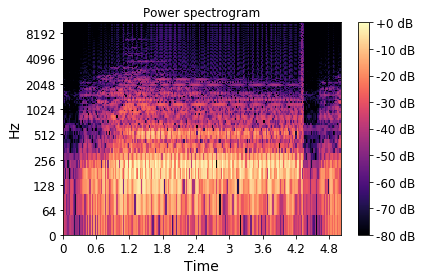

In [35]:
import librosa

sample = librosa.core.stft(y=X_load[0], n_fft=430, win_length=380, window='hamming', center=True, dtype=np.float, pad_mode='reflect')
print(sample.shape)

import matplotlib.pyplot as plt
import librosa.display
librosa.display.specshow(librosa.amplitude_to_db(sample,ref=np.max),y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

In [40]:
import os
import librosa.display

processedData_path = "preprocessedSamples_20480_spect.data"
processedX = np.zeros((len(X_load),216,216,1), dtype=np.float)
#processedX = np.zeros((len(X),513,9), dtype=np.float)
processedy = np.zeros(len(y_load), dtype=np.float)

for i in range(len(X_load)):
    sample = librosa.core.stft(y=X_load[i], n_fft=430, hop_length=None, win_length=380, window='hamming', center=True, dtype=np.float32, pad_mode='reflect')
    sample = np.atleast_3d(sample)
    processedX[i] = sample
    processedy[i] = y_load[i]
    if i % 200 == 0:
        print(i)

C:\Users\vntdeca\AppData\Local\Continuum\Anaconda3\envs\tensorflow_env\lib\site-packages\librosa\core\spectrum.py:180: ComplexWarning: Casting complex values to real discards the imaginary part
  axis=0)[:stft_matrix.shape[0]].conj()


0
200


In [41]:
from sklearn.utils import shuffle
processedX, processedy = shuffle(processedX, processedy)
print(len(processedX))

trainRange = int(len(processedX)*0.7)
validRange = int(len(processedX)*0.2)
testRange = int(len(processedX)*0.1)

X_train = np.array(processedX[:trainRange], dtype=np.float)
y_train = np.array(processedy[:trainRange], dtype=np.float)

X_valid = np.array(processedX[validRange:testRange], dtype=np.float)
y_valid = np.array(processedy[validRange:testRange], dtype=np.float)

X_test = np.array(processedX[testRange:], dtype=np.float)
y_test = np.array(processedy[testRange:], dtype=np.float)
print(y_test[1])
print(X_test[1])

print(X_train.shape,y_train.shape, X_test.shape, y_test.shape)

329
44.0
[[[ -1.26039106e-02]
  [ -2.48116720e-03]
  [  9.16890334e-03]
  ..., 
  [ -9.73468833e-03]
  [  4.31004027e-03]
  [  2.33897753e-02]]

 [[  1.25869289e-02]
  [  1.67017756e-03]
  [ -1.01728104e-02]
  ..., 
  [  1.19751301e-02]
  [ -2.35827593e-03]
  [ -1.62530616e-02]]

 [[ -4.74245986e-03]
  [ -1.73428690e-03]
  [  6.54784590e-03]
  ..., 
  [ -6.98400289e-03]
  [  9.49308509e-04]
  [  3.87564697e-03]]

 ..., 
 [[  1.34254569e-05]
  [  1.03672864e-05]
  [ -1.45092781e-06]
  ..., 
  [  1.96224519e-05]
  [  5.51711594e-07]
  [  6.48088371e-06]]

 [[ -1.18248181e-05]
  [  6.42090981e-06]
  [ -1.81105497e-06]
  ..., 
  [  2.48943725e-05]
  [ -3.17800584e-07]
  [  4.50571815e-06]]

 [[  1.40061375e-05]
  [ -1.51253266e-06]
  [ -2.00572208e-06]
  ..., 
  [  2.66710722e-05]
  [ -8.28249256e-07]
  [  1.38566047e-05]]]
(230, 216, 216, 1) (230,) (297, 216, 216, 1) (297,)


In [49]:
import tensorflow as tf

height = 216
width = 216
channels = 1
n_inputs = height * width

conv1_fmaps = 16
conv1_ksize = 10
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 32
conv2_ksize = 4
conv2_stride = 1
conv2_pad = "SAME"
conv2_dropout_rate = 0.25

pool3_fmaps = conv2_fmaps

n_fc1 = 512
fc1_dropout_rate = 0.4

n_outputs = len(np.unique(y_train))

reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels], name="X")
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 2 * 2])
    pool3_flat_drop = tf.layers.dropout(pool3_flat, conv2_dropout_rate, training=training)

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat_drop, n_fc1, activation=tf.nn.relu, name="fc1")
    fc1_drop = tf.layers.dropout(fc1, fc1_dropout_rate, training=training)

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1_drop, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
def get_model_params():
    gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    return {gvar.op.name: value for gvar, value in zip(gvars, tf.get_default_session().run(gvars))}

def restore_model_params(model_params):
    gvar_names = list(model_params.keys())
    assign_ops = {gvar_name: tf.get_default_graph().get_operation_by_name(gvar_name + "/Assign")
                  for gvar_name in gvar_names}
    init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
    feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
    tf.get_default_session().run(assign_ops, feed_dict=feed_dict)

In [52]:
n_epochs = 1000
batch_size = 10

best_loss_val = np.infty
check_interval = 10
checks_since_last_progress = 0
max_checks_without_progress = 20
best_model_params = None 

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train))
        idx = 0
        for rnd_indices in np.array_split(rnd_idx, len(X_train) // batch_size):
        #for idx in range(len(X_train) // batch_size):
#             print(idx)
#             X_reshaped = np.reshape(X_train[idx],(1, -1))
#             y_reshaped = np.reshape(y_train[idx],(-1))
#             print(X_reshaped.shape)
#             print(y_reshaped.shape)
            X_batch, y_batch = X_train[rnd_indices], y_train[rnd_indices]
            X_batch_reshaped = np.reshape(X_batch,(len(X_batch), -1))
            y_batch_reshaped = np.reshape(y_batch,(len(y_batch), -1))
            sess.run(training_op, feed_dict={X: X_batch_reshaped, y: y_batch, training: True})
            if idx % check_interval == 0:
                X_valid_reshaped = np.reshape(X_valid,(len(X_valid), -1))
                loss_val = loss.eval(feed_dict={X: X_valid_reshaped,
                                                y: y_valid})
                print(loss_val)
                if loss_val < best_loss_val:
                    best_loss_val = loss_val
                    checks_since_last_progress = 0
                    best_model_params = get_model_params()
                else:
                    checks_since_last_progress += 1
            idx += 1
        X_batch_reshaped = np.reshape(X_batch,(len(X_batch), -1))
        acc_train = accuracy.eval(feed_dict={X: X_batch_reshaped, y: y_batch})
        X_valid_reshaped = np.reshape(X_valid,(len(X_valid), -1))
        acc_val = accuracy.eval(feed_dict={X: X_valid_reshaped,
                                           y: y_valid})
        print("Epoch {}, train accuracy: {:.4f}%, valid. accuracy: {:.4f}%, valid. best loss: {:.6f}".format(
                  epoch, acc_train * 100, acc_val * 100, best_loss_val))
        if checks_since_last_progress > max_checks_without_progress:
            print("Early stopping!")
            break

    if best_model_params:
        restore_model_params(best_model_params)
    X_test_reshaped = np.reshape(X_test,(len(X_test), -1))
    acc_test = accuracy.eval(feed_dict={X: X_test_reshaped,
                                        y: y_test})
    print("Final accuracy on test set:", acc_test)
    #save_path = saver.save(sess, "./my_mnist_model")

ValueError: Cannot feed value of shape (10, 1) for Tensor 'inputs/y:0', which has shape '(?,)'